Found 58 local minima: [[ 1  0]
 [ 1  9]
 [ 1 10]
 [ 1 22]
 [ 1 23]
 [ 1 24]
 [ 2  1]
 [ 2  2]
 [ 2  3]
 [ 2  4]
 [ 2  5]
 [ 2  6]
 [ 2  7]
 [ 2  8]
 [ 2 14]
 [ 2 15]
 [ 2 20]
 [ 2 21]
 [ 4 13]
 [ 5 12]
 [ 6 11]
 [ 6 16]
 [ 6 17]
 [ 7 10]
 [ 7 13]
 [ 7 14]
 [ 7 15]
 [ 7 18]
 [ 7 19]
 [ 8  8]
 [ 8  9]
 [11  7]
 [11 14]
 [14 17]
 [15 16]
 [16  1]
 [16  2]
 [16  3]
 [16  4]
 [16  5]
 [16 12]
 [16 15]
 [17  0]
 [17  6]
 [17  7]
 [17  8]
 [17  9]
 [17 10]
 [17 11]
 [17 13]
 [17 14]
 [17 21]
 [17 22]
 [17 23]
 [17 24]
 [18 18]
 [18 19]
 [18 20]]


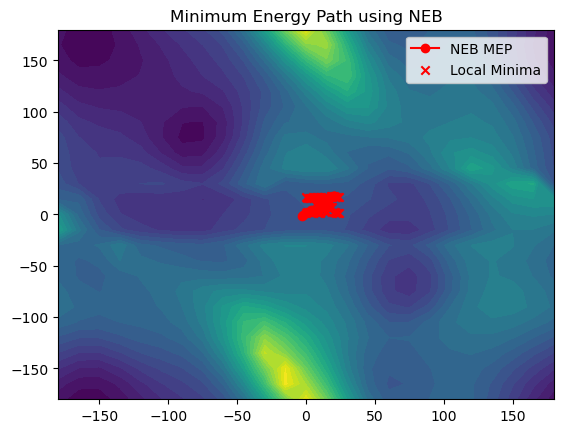

In [8]:
import numpy as np
import scipy.ndimage as ndimage
import scipy.signal as signal
import matplotlib.pyplot as plt

# Load CSV file (assuming format: x, y, z)
data = np.loadtxt("/Users/ramonjr.comendador/cs198-protein-folding/datasets/Y.csv", delimiter=",")
x_vals, y_vals, z_vals = data[:, 0], data[:, 1], data[:, 2]

# Define unique x and y values to create a structured grid
x_unique = np.unique(x_vals)
y_unique = np.unique(y_vals)
X, Y = np.meshgrid(x_unique, y_unique, indexing='ij')

# Reshape z-values to fit the grid
try:
    Z = z_vals.reshape(X.shape)
except ValueError:
    print("Error: The shape of the energy values does not match the grid. Check CSV formatting.")
    exit()

# Ensure periodic boundary conditions (wrap-around)
Z_padded = np.pad(Z, ((1, 1), (1, 1)), mode='wrap')

# Compute energy gradients
grad_x, grad_y = np.gradient(Z_padded)

# Detect local minima using scipy.signal.argrelextrema
minima_x, minima_y = signal.argrelextrema(Z, np.less)

# Get local minima indices
minima_indices = np.array(list(zip(minima_x, minima_y)))

if minima_indices.size == 0:
    print("No local minima found. Selecting manual start and end points.")
    start = (0, 0)
    end = (Z.shape[0] - 1, Z.shape[1] - 1)
else:
    print(f"Found {len(minima_indices)} local minima: {minima_indices}")
    start, end = minima_indices[0], minima_indices[-1]

# Create initial path (linear interpolation)
num_images = 10  # Number of intermediate points
interp_x = np.linspace(start[0], end[0], num_images)
interp_y = np.linspace(start[1], end[1], num_images)
path = np.vstack((interp_x, interp_y)).T

# NEB Iterative Optimization
spring_k = 0.1  # Spring constant between images
alpha = 0.1     # Step size for optimization
tol = 1e-5      # Convergence tolerance

for iteration in range(500):  # Maximum iterations
    # Compute forces: Energy gradient and elastic force
    energy_grads = np.array([grad_x[path[:, 0].astype(int), path[:, 1].astype(int)],
                              grad_y[path[:, 0].astype(int), path[:, 1].astype(int)]]).T

    # Compute elastic (spring) force
    spring_forces = np.diff(path, axis=0)
    spring_forces = np.vstack((spring_forces, np.zeros((1, 2))))  # Fix shape issue

    # Normalize spring forces
    spring_forces[:-1] -= spring_forces[1:]

    # Update path using NEB force balance
    neb_forces = -energy_grads + spring_k * spring_forces
    path += alpha * neb_forces

    # Check convergence
    if np.linalg.norm(neb_forces) < tol:
        print(f"NEB converged in {iteration} iterations.")
        break


# Plot MEP
plt.contourf(X, Y, Z, levels=30, cmap="viridis")
plt.plot(path[:, 1], path[:, 0], 'ro-', label="NEB MEP")
plt.scatter(minima_indices[:, 1], minima_indices[:, 0], c='red', marker='x', label="Local Minima")
plt.legend()
plt.title("Minimum Energy Path using NEB")
plt.show()
